# 載入所需模組

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os


# 讀取資料

In [5]:
# 讀取 Excel 檔案
file_path = "股票資料.xlsx"  # 請將此處替換為你的 Excel 檔案路徑
df = pd.read_excel(file_path,skiprows=6)
df = df.drop(df.index[5:98], axis=0)
# 檢查資料
print("資料前五行：")
print(df.iloc[6:12])

資料前五行：
          Date  Close Change Average Gain Average Loss    EMA 12    EMA 26  \
99  2000-01-24  0.949 -0.045     0.026429       -0.021  0.928027  0.908354   
100 2000-01-25  1.002  0.053     0.020643    -0.024214  0.939408   0.91529   
101 2000-01-26  0.984 -0.018     0.024429    -0.018214  0.946268   0.92038   
102 2000-01-27  0.982 -0.002     0.023429      -0.0195  0.951765  0.924944   
103 2000-01-28  0.907 -0.075     0.023429    -0.013857  0.944878  0.923615   
104 2000-01-31  0.926  0.019     0.020571    -0.019214  0.941974  0.923792   

         DIFF      MACD   Open  ...       Volume  Moving Average  \
99   0.019674  0.009717  0.968  ...  440988800.0         0.77441   
100  0.024117  0.012597  0.938  ...  497201600.0         0.77830   
101  0.025888  0.015255  0.982  ...  367158400.0         0.78184   
102  0.026821  0.017568  0.972  ...  340144000.0         0.78510   
103  0.021263  0.018307  0.966  ...  423360000.0         0.78735   
104  0.018182  0.018282  0.902  ...  7

# 選取特徵及目標

In [6]:
# 選取特徵欄位和目標欄位
features = ['Change', 'Average Gain', 'Average Loss', 'EMA 12', 'EMA 26', 
            'DIFF', 'MACD', 'Open', 'High', 'Low', 'Volume', 
            'Moving Average', 'Relative Strength Index', 'MACD Cylinder']
target = 'Close'

# 準備資料並對其進行縮放處理

In [7]:
# 準備資料
data = df[features + [target]]

# 去除包含非數字的行
data = data.apply(pd.to_numeric, errors='coerce')  # 非數字資料將變為 NaN
data = data.dropna()  # 刪除含有 NaN 的行

# 特徵縮放
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 建立時間序列資料集

In [8]:
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), :-1])  # 使用所有特徵
        y.append(dataset[i + time_step, -1])      # 預測 Close
    return np.array(X), np.array(y)

time_step = 60  # 使用過去 60 天的資料預測下一天
X, y = create_dataset(scaled_data, time_step)

# 分割訓練集與測試集（80% 訓練，20% 測試）

In [9]:
# 分割訓練集與測試集（80% 訓練，20% 測試）
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# LSTM 輸入需三維資料 [樣本數, 時間步長, 特徵數]
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print(y_test.shape)

X_train shape: (4964, 60, 14)
y_train shape: (4964,)
(1241,)


# 建立 LSTM 模型(optimizer = adam, loss = mse)

In [10]:
# 建立 LSTM 模型
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(100, return_sequences=False),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1)  # 輸出單一預測值
])
model.compile(optimizer='adam', loss='mean_squared_error')


# 訓練模型及預測

In [11]:
# 訓練模型
epochs = 50
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_test, y_test), verbose=1)

# 預測
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

Epoch 1/50
156/156 [==============================] - 13s 61ms/step - loss: 3.0434e-04 - val_loss: 0.0326
Epoch 2/50
156/156 [==============================] - 9s 55ms/step - loss: 2.1886e-05 - val_loss: 0.0455
Epoch 3/50
156/156 [==============================] - 8s 54ms/step - loss: 1.2118e-05 - val_loss: 0.0342
Epoch 4/50
156/156 [==============================] - 9s 56ms/step - loss: 2.0237e-05 - val_loss: 0.0367
Epoch 5/50
156/156 [==============================] - 9s 56ms/step - loss: 1.2576e-05 - val_loss: 0.0292
Epoch 6/50
156/156 [==============================] - 9s 55ms/step - loss: 1.6143e-05 - val_loss: 0.0194
Epoch 7/50
156/156 [==============================] - 8s 54ms/step - loss: 1.1167e-05 - val_loss: 0.0216
Epoch 8/50
156/156 [==============================] - 9s 58ms/step - loss: 1.6228e-05 - val_loss: 0.0098
Epoch 9/50
156/156 [==============================] - 9s 55ms/step - loss: 1.2991e-05 - val_loss: 0.0125
Epoch 10/50
156/156 [==============================] -

# 還原預測值與實際值（反向縮放）

In [12]:
def inverse_transform(predictions, scaler, feature_count):
    # 確保 predictions 是一維數據
    if predictions.ndim == 1:
        predictions = predictions.reshape(-1, 1)
    
    extended = np.zeros((len(predictions), feature_count))
    extended[:, -1] = predictions[:, 0]  # 將預測值放在最後一列 (Close 對應位置)
    
    # 進行反向縮放並返回最後一列的值
    return scaler.inverse_transform(extended)[:, -1]


# 修改後的反向縮放
train_predict = inverse_transform(train_predict, scaler, len(features) + 1)
test_predict = inverse_transform(test_predict, scaler, len(features) + 1)

# 直接傳遞 y_test，無需 reshape
y_test_actual = inverse_transform(y_test, scaler, len(features) + 1)


# 評估模型

In [13]:
# 評估模型
mse = mean_squared_error(y_test_actual, test_predict)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, test_predict)
print(f"測試集 MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

測試集 MSE: 57.6570, RMSE: 7.5932, R²: 0.9647


# 視覺化預測結果

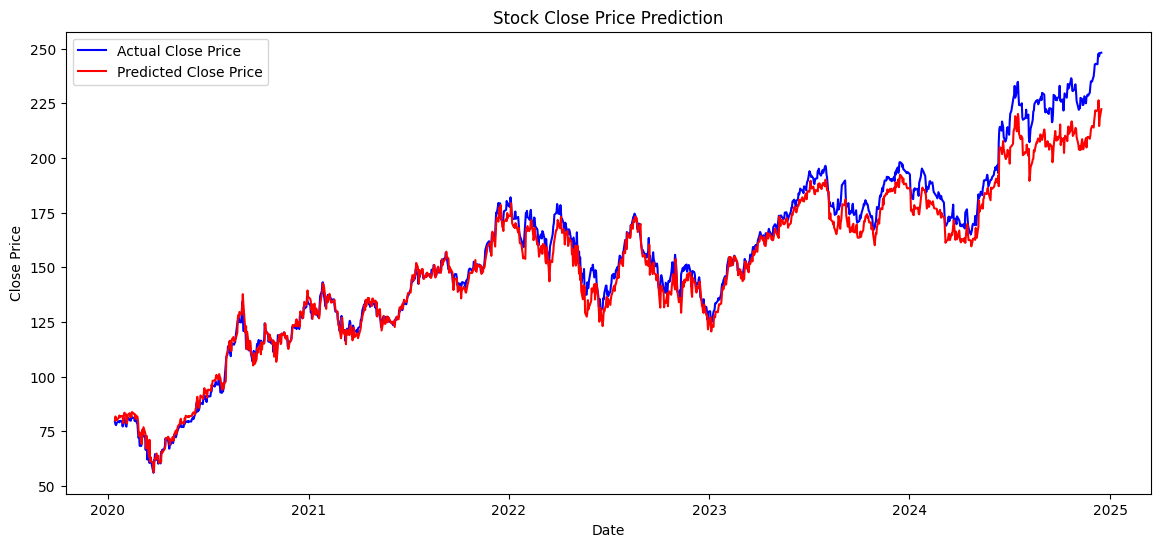

In [14]:
# 視覺化預測結果
plt.figure(figsize=(14, 6))
plt.plot(df['Date'][-len(y_test_actual):], y_test_actual, label="Actual Close Price", color="blue")
plt.plot(df['Date'][-len(test_predict):], test_predict, label="Predicted Close Price", color="red")
plt.title("Stock Close Price Prediction")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# 預測隔天股價

In [68]:

recent_data = scaled_data[-time_step:, :-1]  # 取最近 60 天的數據
# 將數據重塑為 (1, time_steps, features)，這裡 time_steps 是 60，features 是特徵數量
recent_data = recent_data.reshape(1, recent_data.shape[0], recent_data.shape[1])  # (1, time_steps, features)

def predict_tomorrow(model, recent_data, scaler):
    """
    使用 LSTM 模型預測明天的股價。
    :param model: 訓練好的 LSTM 模型
    :param recent_data: 最近 time_steps 天的數據 (time_steps, features)
    :param scaler: 用於數據縮放的 MinMaxScaler
    :return: 預測的明天價格
    """
    input_data = recent_data.copy()
    # 重塑數據為 LSTM 模型所需的 3D 格式
    input_reshaped = input_data.reshape(1, recent_data.shape[1], recent_data.shape[2])

    # 預測明天的 'Close' 價格
    predicted = model.predict(input_reshaped, verbose=0)

    # 反向縮放到原始範圍
    predicted_unscaled = inverse_transform(predicted, scaler, len(features) + 1)

    return predicted_unscaled

# 呼叫函數進行預測
tomorrow_price = predict_tomorrow(model, recent_data, scaler)

# 輸出結果
print("Predicted price for tomorrow:")
print(tomorrow_price)


Predicted price for tomorrow:
[248.27623896]
